# Classifying Galaxies with a Neural Network

This script trains a neural network model on 1400 labeled pictures of galaxies.
Pictures are 128 by 128 pixels and have three channels (rgb) of values 0-255.

There are four galaxy types: 'Normal','Ringed','Merger', and 'Other'.
Thus, baseline prediction accuracy is 25%.

Lastly, the script visualizes the activation of neurons in convolutional layers.

Galaxy data is from https://www.zooniverse.org/projects/zookeeper/galaxy-zoo/


In [1]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
import plotly.io as pio
pio.renderers.default='notebook'
from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))
display(HTML("<style>.output_result { max-width:100% !important; }</style>"))
display(HTML("<style>.prompt { display:none !important; }</style>"))

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 63, 63, 8)         224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 8)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 8)         584       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 392)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                6288      
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 6

Epoch 1/10
70/70 - 2s - loss: 1.3422 - categorical_accuracy: 0.3420 - auc: 0.6031 - val_loss: 1.2672 - val_categorical_accuracy: 0.3679 - val_auc: 0.6637
Epoch 2/10
70/70 - 1s - loss: 1.2121 - categorical_accuracy: 0.4205 - auc: 0.7098 - val_loss: 1.2558 - val_categorical_accuracy: 0.4071 - val_auc: 0.6855
Epoch 3/10
70/70 - 1s - loss: 1.1490 - categorical_accuracy: 0.4857 - auc: 0.7514 - val_loss: 1.1272 - val_categorical_accuracy: 0.4607 - val_auc: 0.7592
Epoch 4/10
70/70 - 1s - loss: 1.1090 - categorical_accuracy: 0.5116 - auc: 0.7759 - val_loss: 1.1035 - val_categorical_accuracy: 0.5679 - val_auc: 0.7825
Epoch 5/10
70/70 - 1s - loss: 1.0583 - categorical_accuracy: 0.5589 - auc: 0.8018 - val_loss: 1.0729 - val_categorical_accuracy: 0.5679 - val_auc: 0.7967
Epoch 6/10
70/70 - 1s - loss: 1.0543 - categorical_accuracy: 0.5688 - auc: 0.8020 - val_loss: 1.0659 - val_categorical_accuracy: 0.5893 - val_auc: 0.7990
Epoch 7/10
70/70 - 1s - loss: 0.9903 - categorical_accuracy: 0.6125 - auc: 0

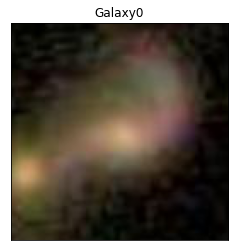

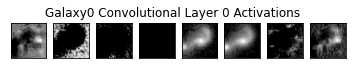

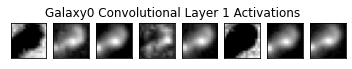

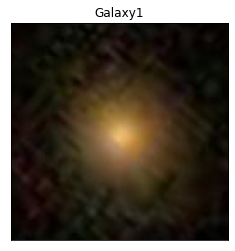

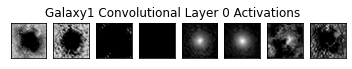

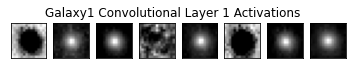

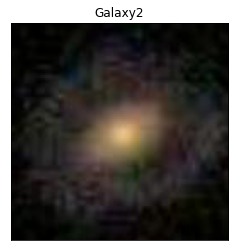

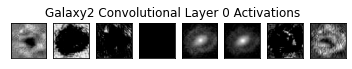

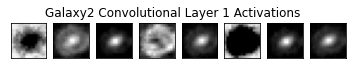

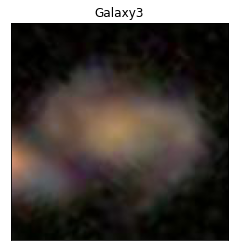

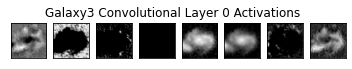

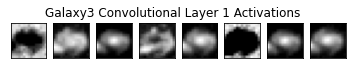

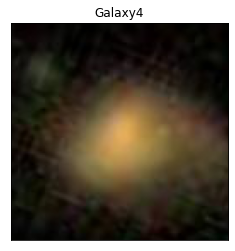

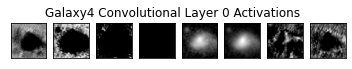

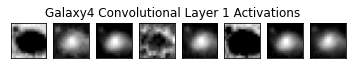

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Conv2D, MaxPooling2D, Flatten, Dense
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import plotly.express as px
import plotly.graph_objects as go
from IPython.core.display import display, HTML
from matplotlib import pyplot as plt


data = np.load('data/neural_network_image_cached_data.npz')
X, y = data['data'], data['labels']

# Equal ratios of label categories in train / test data
x_train, x_valid, y_train, y_valid = train_test_split(X, y,
                                                      test_size=0.2,
                                                      stratify=y)

# Divide 0-255 rgb values by 255 to get values in [0,1]
data_generator = ImageDataGenerator(rescale=1./255.)

batch_size = 16
training_iterator = data_generator.flow(x_train, y_train,
                                        batch_size=batch_size)

validation_iterator = data_generator.flow(x_valid, y_valid,
                                          batch_size=batch_size)

model = tf.keras.Sequential([
    tf.keras.Input(shape=(128,128,3)),
    Conv2D(filters=8, kernel_size=3,strides=2, activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Conv2D(filters=8, kernel_size=3,strides=2, activation='relu'),
    MaxPooling2D(pool_size=(2,2), strides=(2,2)),
    Flatten(),
    Dense(16, activation='relu'),
    Dense(4, activation='softmax'),
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics=[tf.keras.metrics.CategoricalAccuracy(),tf.keras.metrics.AUC()],
              )

display(HTML(f'<br><br><h1>Neural Network Structure'))
model.summary()

display(HTML(f'<br><br><h1>Training Process'))
history = model.fit(training_iterator,
          steps_per_epoch=len(x_train)/batch_size,
          epochs=10,
          validation_data=validation_iterator,
          validation_steps=len(x_valid)/batch_size,
          verbose=2
          )

lenx = len(history.history['auc'])
df_auc = pd.DataFrame({'Training': history.history['auc'] + history.history['categorical_accuracy'],
                       'Validation': history.history['val_auc'] + history.history['val_categorical_accuracy'],
                       'Epoch': list(range(lenx)) * 2,
                       'Metric': ['AUC'] * lenx + ['Accuracy'] * lenx})

df_auc_melted = df_auc.melt(id_vars=['Epoch','Metric'],
                            var_name='Set',
                            value_name='Value')

fig = px.line(df_auc_melted,
                x='Epoch',
                y='Value', color='Set',
                labels=dict(Set='', Value=''),
                title=f'AUC and Accuracy During Training',
                facet_row='Metric', )
_=fig.update_layout(legend=dict(yanchor="middle", y=0.5, xanchor="left", x=0.01),
                  margin=dict(l=10, r=10, b=10, t=70))
fig.update_yaxes(tick0=0.15, dtick=0.1)


display(HTML(f'<br><br><h1>Five Example Galaxies'))

# Model that will output the previous model's activations for each convolutional layer
activation_extractor = tf.keras.Model(
    inputs=model.inputs,
    outputs=[layer.output for layer in model.layers if 'conv2d' in layer.name])

# Remove axes.
def clean_plot(plot):
    plot.axes.get_xaxis().set_visible(False)
    plot.axes.get_yaxis().set_visible(False)

#Dict mapping from class numbers to string labels:
class_names = {0:'Regular',1:'Ringed',2:'Merger',3:'Other'}

#Loads a sample batch of data
sample_batch_input,sample_labels = validation_iterator.next()

#Grabs the first five images
sample_batch_input = sample_batch_input[:5]
sample_labels = sample_labels[:5]

#Makes predictions using model.predict(x)
sample_predictions = model.predict(sample_batch_input)

#Iterate of images, predictions, and true labels
for i,(image, prediction, label) in enumerate(zip(sample_batch_input, sample_predictions, sample_labels)):

    image_name = f'Galaxy{i}'

    #Gets predicted class with highest probability
    predicted_class = tf.argmax(prediction).numpy()

    #Gets correct label
    actual_class = tf.argmax(label).numpy()
    display(HTML(
        f'''
        <hr>
        <h2>{image_name}</h2>
        <p>
        Labels are: ('Normal','Ringed','Merger','Other')
        <br>
        Normal: {prediction[0]:.1%}, Ringed: {prediction[1]:.1%},
         Merger: {prediction[2]:.1%}, Other: {prediction[3]:.1%}
        <br>
        <br>Predicted: {class_names[predicted_class]} ({predicted_class})
        <br>Actual: {class_names[actual_class]} ({actual_class})
        </p>
        '''))

    #Saves image file using matplotlib
    sample_image = image
    clean_plot(plt.imshow(sample_image))

    _=plt.title(f'{image_name}')
    plt.show()
    model_layer_output = activation_extractor(tf.expand_dims(sample_image,0))


#Iterates over each layer output
    for l_num,output_data in enumerate(model_layer_output):

        #Creates a subplot for each filter
        fig, axs = plt.subplots(1, output_data.shape[-1])

        #For each filter
        for i in range(output_data.shape[-1]):

        #Plots the filter's activations
            clean_plot(axs[i].imshow(output_data[0][:, :, i], cmap='gray'))

        _=plt.suptitle(f'{image_name} Convolutional Layer {l_num} Activations',y=0.62)
    plt.show()
